In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

%matplotlib inline

Pi = np.pi

This code solves the KP2 equation

$$
u_{\tau} = -\frac{1}{6}\partial_{\xi}^{3}u - \frac{3}{4}\partial_{\xi}u^{2} - \frac{1}{2}\partial_{\xi}^{-1}\partial_{y}^{2}u,
$$
over a periodic domain given by $[-L,L]\times[-L,L]$ for the initial condition 
$$
u(\xi,y,0) = \sin\left(\frac{\pi}{L}\xi\right)\cos^{3}\left(\frac{\pi}{L}y\right).
$$
Note, in order to maintain my sanity, I finally just used 
$$
\widehat{\left(\partial_{\xi}^{-1}\right)} = \frac{L}{i\pi}\frac{1}{k}, ~ k\neq 0
$$

After taking Fourier-transforms, we can write the above equation in the form
$$
\hat{u}_{\tau} = \mathcal{L}\hat{u} + \mathcal{N}(\hat{u}),
$$
where $L$ denotes the linear part of the problem. When we discretize the equation
$$
\hat{u}_{n+1} = \hat{u}_{n} + \int_{t_{n}}^{t_{n}+\delta t} \mathcal{L}\hat{u} dt + \int_{t_{n}}^{t_{n}+\delta t} \mathcal{N}(\hat{u})dt,
$$
we use the Adams-Moulton-2\* method so that 
$$
\int_{t_{n}}^{t_{n}+\delta t} \mathcal{L}\hat{u} dt \approx \delta t \left(\frac{3}{4}L\hat{u}_{n+1} + \frac{1}{4}L\hat{u}_{n-1} \right).
$$
The integral of the nonlinearity is approximated used a 4-step Adams-Bashforth method.  This gives us an example of an IMEX (Implicit/Explicit) Method in which we use an implicit time stepper to control the negative numerical impacts of the dispersion while avoiding the overhead of using fully implicit time steppers on the integral of the nonlinearity.  See Fornberg and Driscoll, J. Comp. Phys., 155, 1999 for more details.   

In [133]:
def nonlin(Dx,u,KT):
    uphys = (np.fft.ifft2(u.reshape(KT,KT))).real
    unl = np.fft.fft2(uphys*uphys)
    return Dx*unl.flatten()

In [145]:
def kp_solver(K,Llx,tf):
    
    # Total number of modes in simulation is KT=2*K
    # Domain is over [-Llx,Llx]
    # Simulation is run to time tf
    
    dt = 1e-2
    Nsteps = int(np.round(tf/dt))
    
    KT = 2*K
    KTT = KT**2
    
    Xmesh = np.linspace(-Llx,Llx,KT,endpoint=False)
    Xxmesh, Yymesh = np.meshgrid(Xmesh, Xmesh)

    Dds = 1j*Pi/Llx*np.concatenate((np.arange(K+1),np.arange(-K+1,0,1,)),0)
    Dy = np.kron(Dds,np.ones(KT))
    Dx = np.kron(np.ones(KT),Dds)
    
    Dx3 = -1./6.*Dx**3.
    Dy2 = -1./2.*Dy**2.
    
    Dxn1sb = np.concatenate((np.array([0.]),1./Dds[1:]),0)
    Dxn1 = np.kron(np.ones(KT),Dxn1sb)
    
    Dx = -3./4.*Dx
    
    Lop = 1./(np.ones(KTT)-3.*dt/4.*(Dx3+Dxn1*Dy2))
    
    wn = np.zeros(KTT,dtype=np.complex128) # Initialize the solution vector and associated parts of multi-step solver.
    wnm1 = np.zeros(KTT,dtype=np.complex128)
    wnp1 = np.zeros(KTT,dtype=np.complex128)

    nln = np.zeros(KTT,dtype=np.complex128)
    nlnm1 = np.zeros(KTT,dtype=np.complex128)
    nlnm2 = np.zeros(KTT,dtype=np.complex128)
    nlnm3 = np.zeros(KTT,dtype=np.complex128)

    u0 = np.fft.fft2(np.sin(Pi/Llx*Xxmesh)*(np.cos(Pi/Llx*Yymesh))**3.)
    wn[:] =  u0.flatten() # Fourier transform of initial condition
    wnm1[:] = wn

    nln[:] = nonlin(Dx,wn,KT) # Computation of nonlinearity.  
    nlnm1[:] = nln
    nlnm2[:] = nlnm1
    nlnm3[:] = nlnm2
    
    for jj in xrange(Nsteps): # Run the time stepper i.e. how we get from time t_n = ndt to time t_(n+1)
        nln[:] = nonlin(Dx,wn,KT) # Computation of nonlinearity
        wnp1[:] = Lop*(wn + wnm1/3. + dt*(55./24.*nln - 59./24.*nlnm1 + 37./24.*nlnm2 - 3./8.*nlnm3)) - wnm1/3.
    
        wnm1[:] = wn
        wn[:] = wnp1
    
        nlnm3[:] = nlnm2
        nlnm2[:] = nlnm1
        nlnm1[:] = nln
    
    wnp1 = np.fft.ifft2(wnp1.reshape(KT,KT)).real
    fig = plt.figure(figsize=(8, 6))
    plt.pcolor(Xxmesh, Yymesh, wnp1, cmap='RdBu')
    plt.xlabel(r"$\xi$")
    plt.ylabel("$y$")
    plt.colorbar()

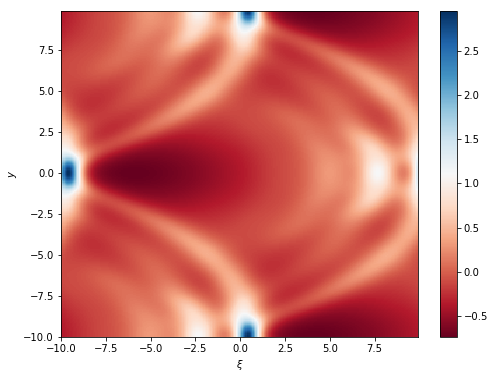

In [146]:
kp_solver(128,10,5.)